In [1]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error

C:\Users\sensho\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from __future__ import print_function

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline
pd.options.display.max_columns = None

In [330]:
#os.chdir('C:/Users/sensho/Documents/Kaggle/HousingPrice')
train_df = pd.read_csv('NTrain_df.csv')
test_df = pd.read_csv('NTest_df.csv')
Gausian_df=pd.read_csv('Gausian_df.csv')
Gausian_test_df=pd.read_csv('Gausian_test_df.csv')
order_list=['LandContour','LotConfig','Neighborhood',
           'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Foundation',
           'Heating','CentralAir','MiscFeature','MasVnrType','SaleCondition','MSSubClass','MoSold','MSZoning',
           'LotShape','SaleType','Exterior2nd','Electrical','GarageType','GarageFinish','Fence','Condition1','Condition2']

#Alleyは欠損値が大量に発生していて、かつ客観的に欠損を埋める方法がわからないため消した
del train_df['Alley']
del test_df['Alley']
del Gausian_df['Alley']

In [331]:
Gausian_df=pd.get_dummies(Gausian_df,columns=order_list)
train_df=pd.get_dummies(data=train_df,columns=order_list)
test_df=pd.get_dummies(data=test_df,columns=order_list)
Gausian_test_df=pd.get_dummies(data=Gausian_test_df,columns=order_list)

In [332]:
target_col='SalePrice'
exclude_cols=['SalePrice','Id']
feature_cols=[col for col in train_df.columns if col not in exclude_cols]

col=set(train_df.columns)
tcol=set(test_df.columns)
exclude_cols=col-tcol
exclude_cols.remove('SalePrice')

for col in exclude_cols:
    test_df[col]=0

In [333]:
ID=test_df['Id']

In [334]:
y=np.array(train_df[target_col])
X=np.array(train_df[feature_cols])
test_df=np.array(test_df[feature_cols])

In [335]:
X.shape,test_df.shape

((1457, 310), (1459, 310))

In [336]:
X_train, X_test, y_train, y_test = \
train_test_split(X,y,test_size=0.3, random_state=0)

In [337]:
X_train1, X_train2, y_train1, y_train2 = \
train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [314]:
lm = LinearRegression()
lm.fit(X_train1, y_train1)
y_pred2 = lm.predict(X_train2)
lm_mse = mean_squared_error(y_train2, y_pred2)
print('LinerRegression MSE: ', lm_mse)

LinerRegression MSE:  1312831571.35


In [315]:
lgb_train=lgb.Dataset(X_train1,y_train1)
gbm=lgb.LGBMRegressor()
gbm.fit(X_train1,y_train1)
y_pred2 = gbm.predict(X_train2)
mod_mse = mean_squared_error(y_train2, y_pred2)
print('RandomForest MSE: ', mod_mse)

RandomForest MSE:  5294823456.06


C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


In [17]:
mod = xgb.XGBRegressor()
mod.fit(X_train1, y_train1)
y_pred2 = mod.predict(X_train2)
mod_mse = mean_squared_error(y_train2, y_pred2)
print('RandomForest MSE: ', mod_mse)

RandomForest MSE:  589747516.972


In [320]:
#変数増加法
def get_gfs_feature_indices(X, y, features, clf):
    X_train_, X_test_, y_train_, y_test_ = \
        train_test_split(X, y, test_size=0.3, random_state=1234)
    feature_indices = {feature: idx for idx, feature in enumerate(features)}
    features = set(features)
    last_mse = np.inf
    chosen_features = set()
    while len(chosen_features) < len(features):
        mse_features = []
        for feature in (features - chosen_features):
            candidates = chosen_features.union(set([feature]))
            indices = [feature_indices[feature] for feature in candidates]
            clf.fit(X_train_[:, indices], y_train_)
            y_pred = clf.predict(X_test_[:, indices])
            mse = mean_squared_error(y_test_, y_pred)
            mse_features += [(mse, feature)]
        mse, feature = min(mse_features)
        if mse >= last_mse:
            break
        last_mse = mse
        print('Newly Added Feature: {},\tMSE Score: {}'.format(feature, mse))
        chosen_features.add(feature)
    return [feature_indices[feature] for feature in chosen_features]

In [276]:
selected_feature_index = \
get_gfs_feature_indices(X=X_train, 
                        y=y_train, 
                        features=feature_cols, 
                        clf= xgb.XGBRegressor())

Newly Added Feature: OverallQual,	MSE Score: 2130349291.1646857
Newly Added Feature: AllSF-2,	MSE Score: 1022106273.611007
Newly Added Feature: BsmtUnfSF,	MSE Score: 813991651.4135363
Newly Added Feature: GarageYrBlt,	MSE Score: 693009483.2202878
Newly Added Feature: AllFlrsSF-2,	MSE Score: 620364524.9873003
Newly Added Feature: OverallGrade,	MSE Score: 536810574.28464305
Newly Added Feature: YearBuilt,	MSE Score: 477798101.71033543
Newly Added Feature: LotShape,	MSE Score: 453531661.33114254
Newly Added Feature: FireplaceQu,	MSE Score: 447624429.5210556
Newly Added Feature: OpenPorchSF,	MSE Score: 417627382.28964233
Newly Added Feature: SaleCondition_Abnorml,	MSE Score: 404169235.5625934
Newly Added Feature: MoSold_Aug,	MSE Score: 399410697.0401612
Newly Added Feature: HeatingQC,	MSE Score: 391197804.0854642
Newly Added Feature: Neighborhood_CollgCr,	MSE Score: 388633352.40986645
Newly Added Feature: MSSubClass_SC75,	MSE Score: 388046244.93003577
Newly Added Feature: Exterior1st_Cemnt

In [ ]:
Newly Added Feature: OverallQual,	MSE Score: 2130349291.1646857
Newly Added Feature: AllSF-2,	MSE Score: 1022106273.611007
Newly Added Feature: BsmtUnfSF,	MSE Score: 813991651.4135363
Newly Added Feature: GarageYrBlt,	MSE Score: 693009483.2202878
Newly Added Feature: AllFlrsSF-2,	MSE Score: 620364524.9873003
Newly Added Feature: OverallGrade,	MSE Score: 536810574.28464305
Newly Added Feature: YearBuilt,	MSE Score: 477798101.71033543
Newly Added Feature: LotShape,	MSE Score: 453531661.33114254
Newly Added Feature: FireplaceQu,	MSE Score: 447624429.5210556
Newly Added Feature: OpenPorchSF,	MSE Score: 417627382.28964233
Newly Added Feature: SaleCondition_Abnorml,	MSE Score: 404169235.5625934
Newly Added Feature: MoSold_Aug,	MSE Score: 399410697.0401612
Newly Added Feature: HeatingQC,	MSE Score: 391197804.0854642
Newly Added Feature: Neighborhood_CollgCr,	MSE Score: 388633352.40986645
Newly Added Feature: MSSubClass_SC75,	MSE Score: 388046244.93003577
Newly Added Feature: Exterior1st_CemntBd,	MSE Score: 387732922.91880375

In [ ]:
from sklearn.model_selection import cross_val_score
learning=[0.05,0.07,0.09,0.1,0.12,0.14,0.16,0.18,0.2]
mod = xgb.XGBRegressor()
params ={'learning_rate':learning}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
mod = xgb.XGBRegressor(learning_rate=0.05,n_estimators=70,max_depth=3,min_child_weight=1,gamma=0.0,colsample_bytree=0.6,subsample=0.9)
params ={'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
r=[]
for i in range(6,10):
    r.append(i/10.0)
    
mod = xgb.XGBRegressor(learning_rate=0.05,n_estimators=70,max_depth=3,min_child_weight=1,gamma=0.0)
params ={'subsample':r,'colsample_bytree':r}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
r=[]
for i in range(0,5):
    r.append(i/10)
mod = xgb.XGBRegressor(learning_rate=0.05,n_estimators=70,max_depth=3,min_child_weight=1)
params ={'gamma':r}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
mod = xgb.XGBRegressor(learning_rate=0.05)
params ={'n_estimators':list(range(10,150,10))}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
mod = xgb.XGBRegressor(learning_rate=0.05,n_estimators=70)
params ={'max_depth':list(range(3,11,1)),'min_child_weight':list(range(1,6,2))}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [179]:
mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.1,max_depth=3,min_child_weight=3,n_estimators=120,colsample_bytree=0.8,subsample=0.6)
params ={'n_estimators':list(range(120,500,10))}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=2,
                   cv=3, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1, y_train1)
gscv.best_params_

Fitting 3 folds for each of 38 candidates, totalling 114 fits
[CV] n_estimators=120 ................................................
[CV] ................................. n_estimators=120, total=   0.3s
[CV] n_estimators=120 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................................. n_estimators=120, total=   0.3s
[CV] n_estimators=120 ................................................
[CV] ................................. n_estimators=120, total=   0.3s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.3s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.3s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.3s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=   0.3s
[CV] n_estimators=140 ................................................
[CV] ................................. n_estimators=140, total=   0.3s
[CV] n_estimators=140 ................................................
[CV] .

[CV] ................................. n_estimators=310, total=   1.0s
[CV] n_estimators=320 ................................................
[CV] ................................. n_estimators=320, total=   1.0s
[CV] n_estimators=320 ................................................
[CV] ................................. n_estimators=320, total=   1.1s
[CV] n_estimators=320 ................................................
[CV] ................................. n_estimators=320, total=   1.0s
[CV] n_estimators=330 ................................................
[CV] ................................. n_estimators=330, total=   1.0s
[CV] n_estimators=330 ................................................
[CV] ................................. n_estimators=330, total=   1.1s
[CV] n_estimators=330 ................................................
[CV] ................................. n_estimators=330, total=   1.0s
[CV] n_estimators=340 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:  1.9min finished


{'n_estimators': 260}

In [252]:
r=[]
for i in range(1,5):
    r.append(i/10)
mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.072,max_depth=4,min_child_weight=1,n_estimators=130,colsample_bytree=0.7,subsample=0.7)
params ={'n_estimators':list(range(130,500,10))}
import sklearn
gscv = GridSearchCV(mod, param_grid=params, verbose=2,cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

Fitting 10 folds for each of 37 candidates, totalling 370 fits
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] ................................. n_estimators=130, total=   0.0s
[CV] n_estimators=130 ................................................
[CV] .

[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] ................................. n_estimators=190, total=   0.0s
[CV] n_estimators=190 ................................................
[CV] .

[CV] ................................. n_estimators=240, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] ................................. n_estimators=250, total=   0.0s
[CV] n_estimators=250 ................................................
[CV] .

[CV] ................................. n_estimators=300, total=   0.1s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total=   0.0s
[CV] n_estimators=300 ................................................
[CV] ................................. n_estimators=300, total=   0.1s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=   0.1s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=   0.1s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=   0.0s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=   0.1s
[CV] n_estimators=310 ................................................
[CV] .

[CV] ................................. n_estimators=360, total=   0.1s
[CV] n_estimators=360 ................................................
[CV] ................................. n_estimators=360, total=   0.1s
[CV] n_estimators=360 ................................................
[CV] ................................. n_estimators=360, total=   0.1s
[CV] n_estimators=360 ................................................
[CV] ................................. n_estimators=360, total=   0.1s
[CV] n_estimators=360 ................................................
[CV] ................................. n_estimators=360, total=   0.1s
[CV] n_estimators=370 ................................................
[CV] ................................. n_estimators=370, total=   0.1s
[CV] n_estimators=370 ................................................
[CV] ................................. n_estimators=370, total=   0.1s
[CV] n_estimators=370 ................................................
[CV] .

[CV] ................................. n_estimators=420, total=   0.2s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.2s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.1s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.1s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.1s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.1s
[CV] n_estimators=420 ................................................
[CV] ................................. n_estimators=420, total=   0.2s
[CV] n_estimators=430 ................................................
[CV] .

[CV] ................................. n_estimators=480, total=   0.2s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.1s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.2s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.1s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.2s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.2s
[CV] n_estimators=480 ................................................
[CV] ................................. n_estimators=480, total=   0.2s
[CV] n_estimators=480 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done 370 out of 370 | elapsed:  1.1min finished


{'n_estimators': 210}

In [ ]:
learning=[0.05,0.07,0.09,0.1,0.12,0.14,0.16,0.18,0.2]
lgb_train=lgb.Dataset(X_train1,y_train1)
#params={'task':'train','boosting_type':'gbdt','objective':'regression','metric':'mse',}
gbm=lgb.LGBMRegressor()
params={'learning_rate':learning}
import sklearn
gscv = GridSearchCV(gbm, param_grid=params, verbose=1,cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
gbm=lgb.LGBMRegressor(learning_rate=0.05)
params={'max_depth':[1,2,3,4,5,6,7],'num_leaves':[2,4,8,16,32,64,128]}
import sklearn
gscv = GridSearchCV(gbm, param_grid=params, verbose=1,cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [ ]:
fraction=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lgb_train=lgb.Dataset(X_train1,y_train1)
gbm=lgb.LGBMRegressor(learning_rate=0.05,max_depth=6,num_leaves=32)
params={'feature_fraction':fraction,'bagging_fraction':fraction}
import sklearn
gscv = GridSearchCV(gbm, param_grid=params, verbose=1,cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

In [64]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
fraction=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
lgb_train=lgb.Dataset(X_train1,y_train1)
gbm=lgb.LGBMRegressor()
params ={'learning_rate':sp_uniform(0.1,0.2),'n_estimators':sp_randint(10,150),\
         'max_depth':sp_randint(1,8),'min_child_weight':sp_randint(1,6)\
        ,'colsample_bytree':r,'subsample':r,'num_leaves':sp_randint(16,500),'feature_fraction':fraction,'bagging_fraction':fraction,
        'bagging_freq':sp_randint(1,5)}
import sklearn
gscv = RandomizedSearchCV(gbm,params, verbose=1,cv=10,n_iter=100, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1[:, selected_feature_index], y_train1)
gscv.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
C:\Users\sensho\Anaconda3\lib\site-packages\lightgbm\basic.py:648: LGBMDeprecationWar

{'bagging_fraction': 0.6,
 'bagging_freq': 1,
 'colsample_bytree': 0.7,
 'feature_fraction': 0.3,
 'learning_rate': 0.16627417617677914,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 149,
 'num_leaves': 477,
 'subsample': 0.6}

In [ ]:
lgb_train=lgb.Dataset(X_train[:, selected_feature_index],y_train)
lgb_eval = lgb.Dataset(X_test[:, selected_feature_index],y_test,reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'min_data_in_leaf':20,
    'min_child_weight':1,
    'colsample_bytree':0.9,
    'subsample':0.8,
    'num_leaves':282,
    'n_estimators':282,
    'max_depth':4,
    'learning_rate': 0.25989877881749829,
    'feature_fraction': 0.9,
    'bagging_fraction': 1,
    'bagging_freq': 2,
    'verbose': 0,
    'reg_lambda':1,
}
gbm = lgb.cv(params,lgb_train,num_boost_round=3500,nfold=10,verbose_eval=20,early_stopping_rounds=15)
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(gbm['l2-mean']))
print('Best CV score:', gbm['l2-mean'][-1])

In [ ]:
lgb_train=lgb.Dataset(X_train[:, selected_feature_index],y_train)
lgb_eval = lgb.Dataset(X_test[:, selected_feature_index],y_test,reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'min_data_in_leaf':20,
    'bagging_fraction': 0.7,
    'bagging_freq': 3,
    'colsample_bytree': 0.8,
    'feature_fraction': 0.8,
    'learning_rate': 0.26718153469989275,
    'max_depth': 7,
    'min_child_weight': 3,
    'n_estimators': 148,
    'num_leaves': 130,
    'subsample': 0.9,
    'verbose': 0,
    'reg_lambda':1,
}
gbm = lgb.cv(params,lgb_train,num_boost_round=3500,nfold=10,verbose_eval=20,early_stopping_rounds=15)
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(gbm['l2-mean']))
print('Best CV score:', gbm['l2-mean'][-1])

In [300]:
X_train, X_test, y_train, y_test = \
train_test_split(X,y,test_size=0.05, random_state=0)

lgb_train=lgb.Dataset(X_train[:, selected_feature_index],y_train)
lgb_eval = lgb.Dataset(X_test[:, selected_feature_index],y_test,reference=lgb_train)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'min_data_in_leaf':20,
    'bagging_fraction': 0.6,
    'bagging_freq': 1,
    'colsample_bytree': 0.7,
    'feature_fraction': 0.3,
    'learning_rate': 0.16627417617677914,
    'max_depth': 5,
    'min_child_weight': 3,
    'n_estimators': 50,
    'num_leaves': 16,
    'subsample': 0.6,
    'verbose': 0,
    'reg_lambda':1,
}
gbm=lgb.LGBMRegressor()
gbm = lgb.train(params,lgb_train,num_boost_round=3500,valid_sets=lgb_eval,early_stopping_rounds=15)

y_pred_on_test=gbm.predict(test_df[:, selected_feature_index],num_iteration=gbm.best_iteration)
output_df = pd.DataFrame(y_pred_on_test,columns=['SalePrice'])
#output_df=np.exp(output_df)
output_df['Id']=ID
output_df=output_df.ix[:,['Id','SalePrice']]
output_df.to_csv('housing_ans.csv', index=False, encoding='utf-8')

[1]	valid_0's l2: 5.79325e+09
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's l2: 5.7863e+09
[3]	valid_0's l2: 5.77499e+09
[4]	valid_0's l2: 5.76557e+09
[5]	valid_0's l2: 5.75453e+09
[6]	valid_0's l2: 5.74823e+09
[7]	valid_0's l2: 5.73724e+09
[8]	valid_0's l2: 5.72787e+09
[9]	valid_0's l2: 5.71745e+09
[10]	valid_0's l2: 5.71118e+09
[11]	valid_0's l2: 5.70053e+09
[12]	valid_0's l2: 5.69071e+09
[13]	valid_0's l2: 5.67971e+09
[14]	valid_0's l2: 5.67348e+09
[15]	valid_0's l2: 5.66269e+09
[16]	valid_0's l2: 5.65342e+09
[17]	valid_0's l2: 5.64258e+09
[18]	valid_0's l2: 5.6364e+09
[19]	valid_0's l2: 5.62544e+09
[20]	valid_0's l2: 5.61623e+09
[21]	valid_0's l2: 5.60626e+09
[22]	valid_0's l2: 5.59952e+09
[23]	valid_0's l2: 5.58875e+09
[24]	valid_0's l2: 5.57951e+09
[25]	valid_0's l2: 5.56964e+09
[26]	valid_0's l2: 5.56294e+09
[27]	valid_0's l2: 5.55209e+09
[28]	valid_0's l2: 5.5429e+09
[29]	valid_0's l2: 5.53252e+09
[30]	valid_0's l2: 5.52644e+09
[31]	valid_0's l2: 5

[274]	valid_0's l2: 3.65942e+09
[275]	valid_0's l2: 3.65203e+09
[276]	valid_0's l2: 3.64537e+09
[277]	valid_0's l2: 3.63854e+09
[278]	valid_0's l2: 3.63453e+09
[279]	valid_0's l2: 3.62702e+09
[280]	valid_0's l2: 3.62076e+09
[281]	valid_0's l2: 3.61441e+09
[282]	valid_0's l2: 3.61061e+09
[283]	valid_0's l2: 3.60319e+09
[284]	valid_0's l2: 3.59718e+09
[285]	valid_0's l2: 3.59045e+09
[286]	valid_0's l2: 3.58662e+09
[287]	valid_0's l2: 3.57939e+09
[288]	valid_0's l2: 3.57323e+09
[289]	valid_0's l2: 3.56629e+09
[290]	valid_0's l2: 3.5621e+09
[291]	valid_0's l2: 3.5548e+09
[292]	valid_0's l2: 3.54868e+09
[293]	valid_0's l2: 3.54311e+09
[294]	valid_0's l2: 3.53886e+09
[295]	valid_0's l2: 3.53169e+09
[296]	valid_0's l2: 3.52582e+09
[297]	valid_0's l2: 3.51906e+09
[298]	valid_0's l2: 3.51486e+09
[299]	valid_0's l2: 3.50734e+09
[300]	valid_0's l2: 3.50122e+09
[301]	valid_0's l2: 3.49447e+09
[302]	valid_0's l2: 3.49069e+09
[303]	valid_0's l2: 3.48331e+09
[304]	valid_0's l2: 3.47749e+09
[305]	vali

[576]	valid_0's l2: 2.27531e+09
[577]	valid_0's l2: 2.27133e+09
[578]	valid_0's l2: 2.26968e+09
[579]	valid_0's l2: 2.26522e+09
[580]	valid_0's l2: 2.26252e+09
[581]	valid_0's l2: 2.25888e+09
[582]	valid_0's l2: 2.25727e+09
[583]	valid_0's l2: 2.25365e+09
[584]	valid_0's l2: 2.25036e+09
[585]	valid_0's l2: 2.24691e+09
[586]	valid_0's l2: 2.24533e+09
[587]	valid_0's l2: 2.2416e+09
[588]	valid_0's l2: 2.23831e+09
[589]	valid_0's l2: 2.2355e+09
[590]	valid_0's l2: 2.23396e+09
[591]	valid_0's l2: 2.23047e+09
[592]	valid_0's l2: 2.22756e+09
[593]	valid_0's l2: 2.2238e+09
[594]	valid_0's l2: 2.22233e+09
[595]	valid_0's l2: 2.21826e+09
[596]	valid_0's l2: 2.2155e+09
[597]	valid_0's l2: 2.21183e+09
[598]	valid_0's l2: 2.21036e+09
[599]	valid_0's l2: 2.20644e+09
[600]	valid_0's l2: 2.20264e+09
[601]	valid_0's l2: 2.19912e+09
[602]	valid_0's l2: 2.19785e+09
[603]	valid_0's l2: 2.19445e+09
[604]	valid_0's l2: 2.19149e+09
[605]	valid_0's l2: 2.18782e+09
[606]	valid_0's l2: 2.18629e+09
[607]	valid_

[834]	valid_0's l2: 1.62564e+09
[835]	valid_0's l2: 1.62321e+09
[836]	valid_0's l2: 1.62063e+09
[837]	valid_0's l2: 1.61863e+09
[838]	valid_0's l2: 1.61775e+09
[839]	valid_0's l2: 1.61498e+09
[840]	valid_0's l2: 1.61253e+09
[841]	valid_0's l2: 1.6103e+09
[842]	valid_0's l2: 1.60865e+09
[843]	valid_0's l2: 1.60634e+09
[844]	valid_0's l2: 1.60391e+09
[845]	valid_0's l2: 1.60177e+09
[846]	valid_0's l2: 1.60053e+09
[847]	valid_0's l2: 1.59835e+09
[848]	valid_0's l2: 1.59623e+09
[849]	valid_0's l2: 1.59412e+09
[850]	valid_0's l2: 1.59205e+09
[851]	valid_0's l2: 1.58964e+09
[852]	valid_0's l2: 1.58792e+09
[853]	valid_0's l2: 1.58602e+09
[854]	valid_0's l2: 1.58478e+09
[855]	valid_0's l2: 1.58244e+09
[856]	valid_0's l2: 1.57998e+09
[857]	valid_0's l2: 1.57774e+09
[858]	valid_0's l2: 1.57569e+09
[859]	valid_0's l2: 1.57313e+09
[860]	valid_0's l2: 1.57108e+09
[861]	valid_0's l2: 1.56876e+09
[862]	valid_0's l2: 1.56751e+09
[863]	valid_0's l2: 1.56502e+09
[864]	valid_0's l2: 1.56287e+09
[865]	val

[1115]	valid_0's l2: 1.14827e+09
[1116]	valid_0's l2: 1.14708e+09
[1117]	valid_0's l2: 1.14537e+09
[1118]	valid_0's l2: 1.14463e+09
[1119]	valid_0's l2: 1.14308e+09
[1120]	valid_0's l2: 1.14086e+09
[1121]	valid_0's l2: 1.13958e+09
[1122]	valid_0's l2: 1.1382e+09
[1123]	valid_0's l2: 1.13682e+09
[1124]	valid_0's l2: 1.13554e+09
[1125]	valid_0's l2: 1.13441e+09
[1126]	valid_0's l2: 1.13379e+09
[1127]	valid_0's l2: 1.1325e+09
[1128]	valid_0's l2: 1.13122e+09
[1129]	valid_0's l2: 1.12935e+09
[1130]	valid_0's l2: 1.12859e+09
[1131]	valid_0's l2: 1.12714e+09
[1132]	valid_0's l2: 1.12653e+09
[1133]	valid_0's l2: 1.12491e+09
[1134]	valid_0's l2: 1.1237e+09
[1135]	valid_0's l2: 1.1223e+09
[1136]	valid_0's l2: 1.12152e+09
[1137]	valid_0's l2: 1.12044e+09
[1138]	valid_0's l2: 1.11971e+09
[1139]	valid_0's l2: 1.1182e+09
[1140]	valid_0's l2: 1.11694e+09
[1141]	valid_0's l2: 1.11551e+09
[1142]	valid_0's l2: 1.11399e+09
[1143]	valid_0's l2: 1.11246e+09
[1144]	valid_0's l2: 1.11095e+09
[1145]	valid_0'

[1412]	valid_0's l2: 8.63718e+08
[1413]	valid_0's l2: 8.62715e+08
[1414]	valid_0's l2: 8.62076e+08
[1415]	valid_0's l2: 8.60931e+08
[1416]	valid_0's l2: 8.60278e+08
[1417]	valid_0's l2: 8.59475e+08
[1418]	valid_0's l2: 8.59404e+08
[1419]	valid_0's l2: 8.58599e+08
[1420]	valid_0's l2: 8.57828e+08
[1421]	valid_0's l2: 8.56429e+08
[1422]	valid_0's l2: 8.55548e+08
[1423]	valid_0's l2: 8.54958e+08
[1424]	valid_0's l2: 8.54357e+08
[1425]	valid_0's l2: 8.53309e+08
[1426]	valid_0's l2: 8.52861e+08
[1427]	valid_0's l2: 8.52008e+08
[1428]	valid_0's l2: 8.52441e+08
[1429]	valid_0's l2: 8.5164e+08
[1430]	valid_0's l2: 8.51184e+08
[1431]	valid_0's l2: 8.49984e+08
[1432]	valid_0's l2: 8.50135e+08
[1433]	valid_0's l2: 8.48827e+08
[1434]	valid_0's l2: 8.48164e+08
[1435]	valid_0's l2: 8.46829e+08
[1436]	valid_0's l2: 8.46245e+08
[1437]	valid_0's l2: 8.46273e+08
[1438]	valid_0's l2: 8.46128e+08
[1439]	valid_0's l2: 8.4512e+08
[1440]	valid_0's l2: 8.43868e+08
[1441]	valid_0's l2: 8.42739e+08
[1442]	valid

[1688]	valid_0's l2: 7.32817e+08
[1689]	valid_0's l2: 7.33146e+08
[1690]	valid_0's l2: 7.32986e+08
[1691]	valid_0's l2: 7.32242e+08
[1692]	valid_0's l2: 7.31999e+08
[1693]	valid_0's l2: 7.31774e+08
[1694]	valid_0's l2: 7.31205e+08
[1695]	valid_0's l2: 7.30729e+08
[1696]	valid_0's l2: 7.30828e+08
[1697]	valid_0's l2: 7.30889e+08
[1698]	valid_0's l2: 7.30432e+08
[1699]	valid_0's l2: 7.2999e+08
[1700]	valid_0's l2: 7.30189e+08
[1701]	valid_0's l2: 7.29526e+08
[1702]	valid_0's l2: 7.29145e+08
[1703]	valid_0's l2: 7.293e+08
[1704]	valid_0's l2: 7.29166e+08
[1705]	valid_0's l2: 7.28971e+08
[1706]	valid_0's l2: 7.28505e+08
[1707]	valid_0's l2: 7.28297e+08
[1708]	valid_0's l2: 7.28165e+08
[1709]	valid_0's l2: 7.28107e+08
[1710]	valid_0's l2: 7.27771e+08
[1711]	valid_0's l2: 7.27748e+08
[1712]	valid_0's l2: 7.27223e+08
[1713]	valid_0's l2: 7.2716e+08
[1714]	valid_0's l2: 7.26639e+08
[1715]	valid_0's l2: 7.26335e+08
[1716]	valid_0's l2: 7.25476e+08
[1717]	valid_0's l2: 7.25113e+08
[1718]	valid_0

[1941]	valid_0's l2: 6.71848e+08
[1942]	valid_0's l2: 6.71937e+08
[1943]	valid_0's l2: 6.71453e+08
[1944]	valid_0's l2: 6.71412e+08
[1945]	valid_0's l2: 6.71791e+08
[1946]	valid_0's l2: 6.71474e+08
[1947]	valid_0's l2: 6.71202e+08
[1948]	valid_0's l2: 6.71126e+08
[1949]	valid_0's l2: 6.72062e+08
[1950]	valid_0's l2: 6.72178e+08
[1951]	valid_0's l2: 6.71615e+08
[1952]	valid_0's l2: 6.71804e+08
[1953]	valid_0's l2: 6.71597e+08
[1954]	valid_0's l2: 6.71192e+08
[1955]	valid_0's l2: 6.71984e+08
[1956]	valid_0's l2: 6.72439e+08
[1957]	valid_0's l2: 6.71972e+08
[1958]	valid_0's l2: 6.7154e+08
[1959]	valid_0's l2: 6.7105e+08
[1960]	valid_0's l2: 6.71002e+08
[1961]	valid_0's l2: 6.69692e+08
[1962]	valid_0's l2: 6.6949e+08
[1963]	valid_0's l2: 6.6909e+08
[1964]	valid_0's l2: 6.69251e+08
[1965]	valid_0's l2: 6.68987e+08
[1966]	valid_0's l2: 6.69503e+08
[1967]	valid_0's l2: 6.69138e+08
[1968]	valid_0's l2: 6.68811e+08
[1969]	valid_0's l2: 6.68523e+08
[1970]	valid_0's l2: 6.68134e+08
[1971]	valid_0

In [497]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
learning=[0.05,0.07,0.09,0.1,0.12,0.14,0.16,0.18,0.2]
r=[]
for i in range(6,10):
    r.append(i/10.0)
mod = xgb.XGBRegressor(reg_lambda=1,gamma=0.0)
params ={'learning_rate':sp_uniform(0.05,0.2),'n_estimators':list(range(10,150,10)),\
         'max_depth':list(range(3,11,1)),'min_child_weight':list(range(1,6,2))\
        ,'colsample_bytree':r,'subsample':r}
#繰り返し処理計算式＝cv * n_iter
import sklearn
gscv =RandomizedSearchCV(mod, params, verbose=1,
                   cv=3,n_iter=1000, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1, y_train1)
gscv.best_params_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 20.1min finished


{'colsample_bytree': 0.6,
 'learning_rate': 0.12773974787172604,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 120,
 'subsample': 0.8}

In [180]:
#k分割交差検証によるモデル評価　p171
from sklearn.cross_validation import cross_val_score

mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.1,max_depth=3,min_child_weight=3,n_estimators=260,colsample_bytree=0.8,subsample=0.6)
scores=cross_val_score(estimator=mod,X=X_train,y=y_train,scoring='mean_squared_error',cv=10,n_jobs=-1)
print('CV mse scores: %s' % scores)
print('CV mse: %.3f +/- %.3f'%(np.mean(scores),np.std(scores)))

CV mse scores: [ -5.07567668e+08  -4.32696654e+08  -2.73529565e+08  -3.65033234e+08
  -5.95990414e+08  -1.02059601e+09  -6.67853469e+08  -3.26257483e+08
  -3.92864775e+08  -5.56278728e+08]
CV mse: -513866800.468 +/- 206254669.069


In [168]:
#k分割交差検証によるモデル評価　p171
from sklearn.cross_validation import cross_val_score

mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.15124835871864328,max_depth=3,min_child_weight=3,n_estimators=120,colsample_bytree=0.8,subsample=0.6)
scores=cross_val_score(estimator=mod,X=X_train,y=y_train,scoring='neg_mean_squared_error',cv=10,n_jobs=-1)
print('CV mse scores: %s' % scores)
print('CV mse: %.3f +/- %.3f'%(np.mean(scores),np.std(scores)))
#注意　cross_val_scoreのMSEは仕様により-1倍される

CV mse scores: [ -4.97999556e+08  -4.63283891e+08  -2.94695662e+08  -3.97933078e+08
  -6.30135760e+08  -1.17941523e+09  -6.43686615e+08  -4.52205309e+08
  -4.77339610e+08  -6.13682090e+08]
CV mse: -565037680.179 +/- 229462036.894


In [356]:
mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.15124835871864328,max_depth=3,min_child_weight=3,n_estimators=120,colsample_bytree=0.8,subsample=0.6)
mod.fit(X,y)
y_pred_on_test = mod.predict(test_df)

output_df = pd.DataFrame(y_pred_on_test,columns=['SalePrice'])
#output_df=np.expm1(output_df)
output_df['Id']=ID
output_df=output_df.ix[:,['Id','SalePrice']]
output_df.to_csv('housing_ans.csv', index=False, encoding='utf-8')

In [21]:
output_df.head(5)

,Id,SalePrice
0,1461,121906.726562
1,1462,162497.453125
2,1463,183630.390625
3,1464,193557.453125
4,1465,183101.687500


In [22]:
y_pred_on_test =mod.predict(X_test)
mod_mse = mean_squared_error(y_test, y_pred_on_test)
print('XGB MSE: ', mod_mse)

XGB MSE:  500042872.475


In [173]:
y_pred_on_test =mod.predict(X_test)
mod_mse = mean_squared_error(y_test, y_pred_on_test)
print('XGB MSE: ', mod_mse)

XGB MSE:  153423768.289


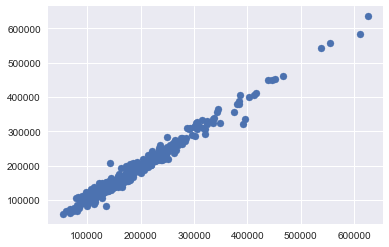

In [174]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
plt.scatter(y_test, y_pred_on_test)
#解析の結果バギングorランダムフォレストのアンサンブルを使えばもっと精度が良くなると思う

In [181]:
#10の分類器を作りその平均値を算出
#抽出数は訓練用データ全て使用して復元抽出（重複あり）
mod=xgb.XGBRegressor(reg_lambda=1,gamma=0.0,learning_rate= 0.15124835871864328,max_depth=3,min_child_weight=3,n_estimators=120,colsample_bytree=0.8,subsample=0.6)
y_pred_on_test=np.zeros(1459)
import random
for i in range(0,100):
    sampling=np.ones((1457,310))
    sampling_y=np.zeros(1457)
    for j in range(0,1457):
        element=np.random.randint(0,1457)
        sampling[[j]]=X[[element]]
        sampling_y[j]=y[element]
    mod.fit(sampling,sampling_y)
    y_prediction= mod.predict(test_df)
    y_pred_on_test+=y_prediction

y_pred_on_test=y_pred_on_test/100
output_df = pd.DataFrame(y_pred_on_test,columns=['SalePrice'])
output_df['Id']=ID
output_df=output_df.ix[:,['Id','SalePrice']]
output_df.to_csv('housing_ans.csv', index=False, encoding='utf-8')

In [318]:
#Lasso線形回帰
from sklearn.linear_model import Lasso
lasso=Lasso(tol=0.025)
params ={'alpha':[0.1, 0.5, 0.8, 1]}
import sklearn
gscv = GridSearchCV(lasso, param_grid=params, verbose=1,
                   cv=10, scoring='neg_mean_squared_error',n_jobs=1)
gscv.fit(X_train1, y_train1)
gscv.best_params_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s finished


{'alpha': 1}

In [353]:
lasso=Lasso(alpha=1,tol=0.07)
lasso.fit(X_train,y_train)
y_pred_on_test =lasso.predict(X_test)
mod_mse = mean_squared_error(y_test, y_pred_on_test)
print('XGB MSE: ', mod_mse)

XGB MSE:  563449560.087


In [355]:
y_pred =mod.predict(X_test)
y_pred_on_test =lasso.predict(X_test)
y_pred_on_test +=y_pred
y_pred_on_test =y_pred_on_test/2
mod_mse = mean_squared_error(y_test, y_pred_on_test)
print('XGB MSE: ', mod_mse)

XGB MSE:  438176056.808


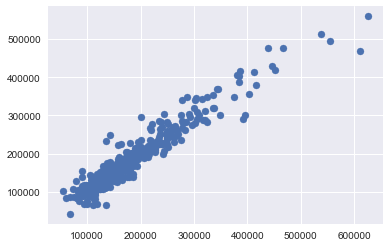

In [347]:
plt.scatter(y_test, y_pred_on_test)

In [ ]:
#テストデータに目的変数'SalePrice'を追加
test_df['SalePrice']=ans_df['SalePrice']
train_df.shape,test_df.shape,ans_df.shape

In [ ]:
#前処理
cate_df=train_df.describe(include=['O'])
cate_test_df=test_df.describe(include=['O'])

col=cate_df.columns.values
col_test=cate_test_df.columns.values

cate_df=train_df[col]
cate_test_df=test_df[col_test]

cate_df=pd.get_dummies(cate_df)
cate_test_df=pd.get_dummies(cate_test_df)

mean_price={}
test_mean_price={}
for tval,val in zip(cate_test_df,cate_df):
        test_mean_price[tval]=0
        mean_price[val]=0

cate_df['SalePrice']=train_df['SalePrice']
cate_test_df['SalePrice']=test_df['SalePrice']

for col in cate_df:
    df_temp=cate_df[[col,'SalePrice']] 
    df=df_temp[df_temp[col]==1]['SalePrice']
    mean_price[col]=df.mean()

for col in cate_test_df:
    df_temp=cate_test_df[[col,'SalePrice']]
    df=df_temp[df_temp[col]==1]['SalePrice']
    test_mean_price[col]=df.mean()

del test_mean_price['SalePrice']
del mean_price['SalePrice']

In [ ]:
#ユニーク変数に平均値代入
for col in train_df:
    for key,val in mean_price.items():
        first_sentence=key.split('_')[1]
        if col == key.split('_')[0]:
            train_df.loc[train_df[col]==str(first_sentence),col]=val

for col in test_df:
    for key,val in test_mean_price.items():
        first_sentence=key.split('_')[1]
        if col==key.split('_')[0]:
            test_df.loc[test_df[col]==str(first_sentence),col]=val
    

In [ ]:
#Trainデータの欠損値確認
Nan=[]
for col in train_df:
    if train_df[col].isnull().any()==True:
        Nan.append(col)
Nan_df= pd.DataFrame()     
for col in train_df:
    for nan in Nan:
        if nan==col:
            Nan_df[col]=train_df[col]
dic={}    
dic=Nan_df.isnull().sum()    
Nan_df.isnull().sum()

In [ ]:
#テストデータの欠損値確認
Nan=[]
for col in test_df:
    if test_df[col].isnull().any()==True:
        Nan.append(col)
Nan_df= pd.DataFrame()     
for col in test_df:
    for nan in Nan:
        if nan==col:
            Nan_df[col]=test_df[col]
dic_test={}    
dic_test=Nan_df.isnull().sum()
Nan_df.isnull().sum()

In [ ]:
#欠損値が多い変数は削除
drop=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
train_df=train_df.drop(drop, axis=1)

In [ ]:
drop=[]
drop=['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
test_df=test_df.drop(drop,axis=1)

In [ ]:
#最頻値で補完したい欠損地がある変数の抽出
Nan=[]
Nan_test=[]
for key,val in dic.items():
    if val<=8:
        Nan.append(key)

for key,val in dic_test.items():
    if val<=16:
        Nan_test.append(key)
Nan_test  

In [ ]:
from sklearn.preprocessing import Imputer
#  欠測値(NaN) に対して 最頻値(most_frequent) を割り当てるImputerオブジェクトを生成
imp = Imputer(missing_values="NaN", strategy="most_frequent")

# データセットの学習 + strategy="most_frequent"に基づいて欠測値(NaN)を中央値に置き換える
for col in Nan:
    values = imp.fit_transform(train_df[[col]])    
    train_df[[col]] = values

for col in Nan_test:
    values = imp.fit_transform(test_df[[col]])
    test_df[[col]] = values

In [ ]:
Nan=[]
for col in test_df:
    if test_df[col].isnull().any()==True:
        Nan.append(col)
Nan_df= pd.DataFrame()     
for col in test_df:
    for nan in Nan:
        if nan==col:
            Nan_df[col]=test_df[col]
dic_test={}    
dic_test=Nan_df.isnull().sum()
Nan_df.isnull().sum()

In [ ]:
Nan=[]
for col in train_df:
    if train_df[col].isnull().any()==True:
        Nan.append(col)
Nan_df= pd.DataFrame()     
for col in train_df:
    for nan in Nan:
        if nan==col:
            Nan_df[col]=train_df[col]
dic={}    
dic=Nan_df.isnull().sum()    
Nan_df.isnull().sum()

In [ ]:
#trainデータの欠損値補完
cate_df=train_df.describe()
cate_test_df=test_df.describe()
colum=cate_df.columns.values
colum_test=cate_test_df.columns.values

for col in colum:
    for key in dic.keys():
        if col==key:
            imp = Imputer(missing_values="NaN", strategy="mean")
            values = imp.fit_transform(train_df[[col]])    
            train_df[[col]] = values
            del dic[col]
            
            
for col in colum_test:
    for key in dic_test.keys():
        if col==key:
            imp = Imputer(missing_values="NaN", strategy="mean")
            values = imp.fit_transform(test_df[[col]])    
            test_df[[col]] = values
            del dic_test[col]

imp = Imputer(missing_values="NaN", strategy="most_frequent")

# テストデータの補完
for col in dic.keys():
    values = imp.fit_transform(train_df[[col]])    
    train_df[[col]] = values

for col in dic_test.keys():
    values = imp.fit_transform(test_df[[col]])
    test_df[[col]] = values